<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_08_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.08 Transformer

* 날짜:
* 이름:

## 학습내용
  - Transformer을 이해하고 구현한다.
  - Vision Transformer을 이해하고 구현한다.

## 참고 사이트

   - 논문 [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf)


In [1]:
import sys, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, utils

## 모듈 제작
---

### **| Multi Head Attention**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-09.PNG?raw=true?raw=true?raw=true
 width=350>
</p>

* set params

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-01.PNG?raw=true?raw=true
 width=850>
</p>


In [ ]:
h = 8 
d_k = 64
d_v  = 64
d_model = 64 * h #512  = embeding dims

# 인풋 x shape 
# 시계열 : ( time range(window_size), channel )
# 텍스트 : ( max lenth , vocab size )
# 텍스트 임베딩 : (max lenth, embeding dims)

# -> (V, K, Q)
# T = S = max lenth
# d_model = embedding dims
T = 200
S = 100

Q = (T, d_model)
K = (S, d_model)
V = (S, d_model)
print(Q)
print(K)
print(V)

(200, 512)
(100, 512)
(100, 512)


In [ ]:
def matmul(shape1, shape2):
  assert shape1[1]==shape2[0]
  return (shape1[0], shape2[1])
A = (100, 300)
B = (300, 200)
matmul(A, B)

(100, 200)

* Step1. Linear each  $Q, K, V(W^Q, W^K, W^V)$

<br>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-05.PNG?raw=true?raw=true?raw=true
 width=250>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-02-1.PNG?raw=true?raw=true
 width=850>
</p>



In [ ]:
# set weights
W_Q = (d_model, d_k)
W_K = (d_model, d_k)
W_V = (d_model, d_v) 

# calculate shape
VW = matmul(V, W_V) 
KW = matmul(K, W_K) 
QW = matmul(Q, W_Q) 

print(f'Q {Q} x W_Q {W_Q} = {QW}')
print(f'K {K} x W_K {W_K} = {KW}')
print(f'V {V} x W_V {W_V} = {VW}')

Q (200, 512) x W_Q (512, 64) = (200, 64)
K (100, 512) x W_K (512, 64) = (100, 64)
V (100, 512) x W_V (512, 64) = (100, 64)


* Step2. Attention


<p align='center'>
<img src=https://wikidocs.net/images/page/159310/mha_img_original.png?raw=true
 width=450>
</p>


<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-03.PNG?raw=true?raw=true
 width=850>
</p>

In [ ]:
KW_T = (KW[1], KW[0])
print(f"QW: {QW}, KW_T: {KW_T}, VW: {VW}")

Att = matmul( matmul(QW, KW_T), VW )
print(f'Attention(QW, KW, VW) : {Att}')

QW: (200, 64), KW_T: (64, 100), VW: (100, 64)
Attention(QW, KW, VW) : (200, 64)


* step3. concat & Linear $(W^O)$

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-10.PNG?raw=true?raw=true?raw=true
 width=300>
</p>

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-04.PNG?raw=true?raw=true
 width=850>
</p>

In [ ]:
print(f'- Attention(QW, KW, VW) = head {Att}')

concat_att = (Att[0], Att[1]*h)
print(f'- Concat(head_1, ...head_h) {concat_att}')

W_O = ((h*d_v), d_model)
final_out = matmul(concat_att, W_O)
print(f'- Concat {concat_att} x W_O {W_O} = final output: {final_out}' )

- Attention(QW, KW, VW) = head (200, 64)
- Concat(head_1, ...head_h) (200, 512)
- Concat (200, 512) x W_O (512, 512) = final output: (200, 512)


In [ ]:
print('- 인풋: ',  V, K, Q)
print(f'- 최종 아웃풋: {final_out}')

- 인풋:  (100, 512) (100, 512) (200, 512)
- 최종 아웃풋: (200, 512)


#### Tensorflow.keras MultiHeadAttention Layer

* docs: https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention

```
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
)

# call args

query	Query Tensor of shape (B, T, dim).
value	Value Tensor of shape (B, S, dim).
key	Optional key Tensor of shape (B, S, dim). If not given, will use 
```

In [ ]:
h = 8 
d_k = 64
d_model = 64 * h #512  = embeding dims

T = 200
S = 100

Q = layers.Input(shape=(T, d_model))
V = layers.Input(shape=(S, d_model))

y = layers.MultiHeadAttention(num_heads = h,
                              key_dim = d_k,
                              )(Q, V)
                          

In [ ]:
print(f'- 인풋: V {V.shape} K {K.shape} Q {Q.shape}')
print(f'- 최종 아웃풋: {y.shape}')

- 인풋: V (None, 100, 512)
- 최종 아웃풋: (None, 2)


### **| Encoder Block**

<p align='center'>
<img src=https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0408-11.PNG?raw=true?raw=true
 width=250>
</p>

In [ ]:
def encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    # multi-head
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(inputs, inputs)
    y = layers.Dropout(dropout)(y)                        
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    y_1 = layers.Add()([y, inputs])

    # Feed Forward Part
    # FF
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y_1)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    # Add & Norm
    y = layers.LayerNormalization(epsilon=1e-6)(y)
    outputs = layers.Add()([y, y_1])

    return models.Model(inputs, outputs, name=name)

In [ ]:
input_shape = (200, 128)
h = 8
d_k = 16
d_ff = 32
encoder = encoder_block(input_shape,
                        h, 
                        d_k, 
                        d_ff)
utils.plot_model(encoder, show_shapes=True)

## 실습1. 시계열 데이터 분류
---

### **| 시계열 데이터셋**

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

(3601, 500, 1) (3601,)


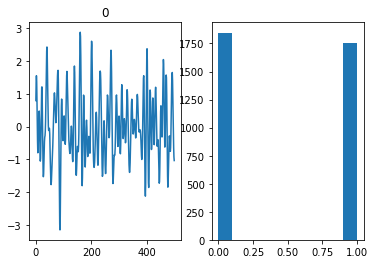

In [ ]:
print(x_train.shape, y_train.shape)

idx = 10
plt.subplot(121)
plt.title(y_train[idx])
plt.plot(x_train[idx])
plt.subplot(122)
plt.hist(y_train)
plt.show()


### **| 모델 구현**

In [ ]:
### Set params
input_shape = (500, 1) # ( T/S , d_model)
n_classes = 2

N = 4
h = 4
d_k = 128
d_ff = 4

### 모델 구현

# Set Input
inputs = layers.Input(shape=input_shape)

# Encoder Block
y = inputs
for i in range(N):
  encoder = encoder_block(input_shape, 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)

# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 500, 1)]          0         
                                                                 
 encoder_0 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_1 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_2 (Functional)      (None, 500, 1)            3602      
                                                                 
 encoder_3 (Functional)      (None, 500, 1)            3602      
                                                                 
 global_average_pooling1d_6   (None, 500)              0         
 (GlobalAveragePooling1D)                                        
                                             

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data=[x_test, y_test],
          epochs = 50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50
57/57 [==============================] - 28s 207ms/step - loss: 1.1684 - acc: 0.5176 - val_loss: 0.7986 - val_acc: 0.5591
Epoch 2/50
57/57 [==============================] - 11s 196ms/step - loss: 0.9287 - acc: 0.5648 - val_loss: 0.7021 - val_acc: 0.6053
Epoch 3/50
57/57 [==============================] - 11s 195ms/step - loss: 0.8524 - acc: 0.5862 - val_loss: 0.6504 - val_acc: 0.6439
Epoch 4/50
12/57 [=====>........................] - ETA: 7s - loss: 0.8128 - acc: 0.5964

## 실습2. IMDB 텍스트 분류
---

### **| IMDB 데이터셋**


In [ ]:
vocab_size = 20000  
maxlen = 200  

(x_train, y_train), (x_val, y_val) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
print(x_train.shape, x_val.shape)

17473536/17464789 [==============================] - 0s 0us/step
25000 Training sequences
25000 Validation sequences
(25000, 200) (25000, 200)


In [ ]:
# 200 -> (200, embedding)

In [ ]:
# 데이터가 정하는 값
maxlen = 200
vocab_size = 20000

# 하이퍼파라미터
embed_dim = 128

x = layers.Input(shape = (maxlen,))
x_em = layers.Embedding(input_dim = vocab_size,  
                        output_dim = embed_dim)(x)
print(x.shape, x_em.shape)


(None, 200) (None, 200, 128)


In [ ]:
class TokenAndPositionEmbedding(layers.Layer): # 상속: tf.keras의 Layer를 상속받는다.
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__() # 부모 클래스의 초기값들을 가져오기
        
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # 기본 임베딩 
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # Positional encoding
        self.maxlen = maxlen
    def call(self, x):
        # maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
# call이 하는 기능

# embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# embed(x)


# x_embed = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim )(x)
# print(x_embed)


### **| 모델 구현**

In [ ]:
### Set params

maxlen = 200
vocab_size = 20000
embed_dim = 32
n_classes = 2

N = 4
h = 4
d_k = 32
d_ff = 32

### 모델 구현

# Set Input
inputs = layers.Input(shape=(maxlen,))

# Embedding : (maxlen) -> (maxlen, embed_dim)
y_emb = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)

# Encoder Block
y = y_emb # y.shape: [None, maxlen, embed_dim]
for i in range(N):
  encoder = encoder_block(y.shape[1:], 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.GlobalAveragePooling1D(data_format='channels_first')(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(n_classes, activation='softmax')(y)

# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()


# Set Input

# Encoder Block


# Classifier

# Final model


Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 encoder_0 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_1 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_2 (Functional)      (None, 200, 32)           19040     
                                                                 
 encoder_3 (Functional)      (None, 200, 32) 

### **| 학습**

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics='acc')
es = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
model.fit(x_train, y_train,
          validation_data=[x_val, y_val],
          epochs = 50,
          batch_size=64,
          callbacks=[es])

Epoch 1/50
391/391 [==============================] - 34s 50ms/step - loss: 0.6219 - acc: 0.6237 - val_loss: 0.3873 - val_acc: 0.8264
Epoch 2/50
391/391 [==============================] - 19s 48ms/step - loss: 0.3076 - acc: 0.8720 - val_loss: 0.3244 - val_acc: 0.8683
Epoch 3/50
391/391 [==============================] - 19s 50ms/step - loss: 0.2231 - acc: 0.9162 - val_loss: 0.3859 - val_acc: 0.8580
Epoch 4/50
391/391 [==============================] - 19s 48ms/step - loss: 0.1612 - acc: 0.9428 - val_loss: 0.3562 - val_acc: 0.8683
Epoch 5/50
391/391 [==============================] - 19s 49ms/step - loss: 0.1334 - acc: 0.9536 - val_loss: 0.4325 - val_acc: 0.8614
Epoch 6/50
391/391 [==============================] - 19s 48ms/step - loss: 0.0990 - acc: 0.9682 - val_loss: 0.5414 - val_acc: 0.8416
Epoch 7/50
391/391 [==============================] - 19s 48ms/step - loss: 0.0835 - acc: 0.9738 - val_loss: 0.6511 - val_acc: 0.8587
Epoch 8/50
391/391 [==============================] - 19s 48ms

## 실습3. Vision Transformer
---

In [2]:
def display_img_patches(img, patches=None):

  # origin image
  plt.imshow(img)
  plt.axis('off')
  plt.show()
 
  if patches is not None:
    n = int(np.sqrt(patches.shape[0]))
    patch_size = int(img.shape[0]/n)

    # patch imgs
    plt.figure(figsize=(4, 4))
    for i, patch in enumerate(patches):
      ax = plt.subplot(n, n, i + 1)
      patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
      plt.imshow(patch_img.numpy().astype("uint8"))
      plt.axis("off")
    plt.show()

    # patches
    plt.figure(figsize=(10, 2))
    for i, patch in enumerate(patches):
      ax = plt.subplot(1, n*n, i + 1)
      patch = tf.expand_dims(patch, 1)
      plt.imshow(patch.numpy().astype("uint8"))
      plt.axis("off")
    plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data() # 100개의 클래스 
x_train.shape, y_train.shape

169017344/169001437 [==============================] - 4s 0us/step


((50000, 32, 32, 3), (50000, 1))

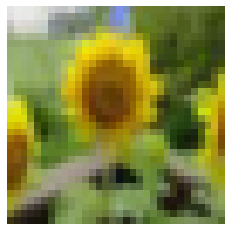

In [6]:
idx = 12
display_img_patches(x_train[idx])

### **| 이미지 증강**

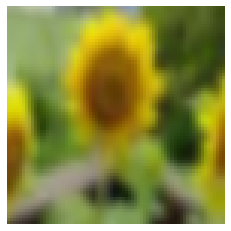

((32, 32, 3), TensorShape([72, 72, 3]))

In [10]:
def aug_model(resize = 72):
    # 전처리
    aug_layers = [layers.Normalization(), # 정규화  1/255
                    layers.Resizing(resize, resize),    # 리사이즈
                    # 증강 
                    layers.RandomFlip(mode = 'horizontal'), # 랜덤플립
                    layers.RandomRotation(factor = 0.02),   # 랜덤회전
                    layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)]   # 랜덤확대

    model = tf.keras.Sequential(aug_layers, name = 'ImgAug')
    return model

# train / valid / test : train set에만 자동적으로 증강 레이어가 적용  

x_img = x_train[idx]
x_aug = aug_model()(x_img)

display_img_patches(x_aug.numpy().astype('uint8'))

x_img.shape, x_aug.shape    

### **| Patch 생성**

In [47]:

class MakePatchLayer(layers.Layer):
    def __init__(self, patch_size):
        super(MakePatchLayer, self).__init__()
        self.patch_size = patch_size

    def call(self, imgs): # ( batch, h, w, ch)
        # BUT, x_aug.shape = (72, 72, 3)
    
        x_patches = tf.image.extract_patches(images = imgs, 
                                            sizes = [1, self.patch_size, self.patch_size, 1] , # patch size가 1이란 말은 그대로
                                            strides = [1, self.patch_size, self.patch_size, 1],
                                            rates = [1, 1, 1, 1],
                                            padding = 'VALID',
                                            )
        # (batch_size, H patch 개수, W patch 개수, patch 차원((patch size**2)* 3))
        batch_size = tf.shape(x_patches)[0]
        d_patches = tf.shape(x_patches)[-1]

        x_patches = tf.reshape(x_patches, [batch_size, -1, d_patches])
        # (batch_size, patch개수, patch 차원)
        return x_patches


(1, 72, 72, 3) (1, 36, 432)


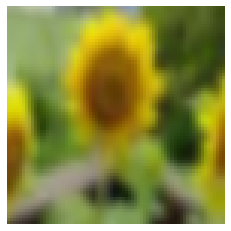

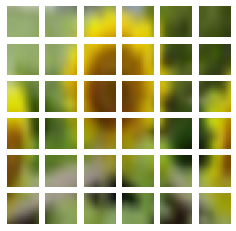

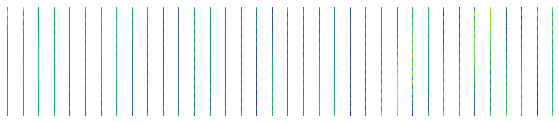

In [18]:
x_patches = MakePatchLayer(12)(x_aug)
print(x_aug.shape, x_patches.shape)
display_img_patches(x_aug[0].numpy().astype('uint8'), x_patches[0])

### **| Patch Encoder**

In [22]:
project_dim = 128
num_patches = tf.shape(x_patches)[1]
print(f'-flatten patches: {x_patches.shape}')

# patch linear projection 
projected = layers.Dense(project_dim)(x_patches)
print(f'-projected patches: {projected.shape}')

# position embedding
positions = tf.range(0, num_patches, 1)
print(f'-positions: {positions}, num_patches: {num_patches}')
embed = layers.Embedding(num_patches, project_dim)(positions)
print(f'-embedded positions: {embed.shape}')

# position + patch encoding
encoded = projected + embed
print(f'- encoding result: {encoded.shape}')

-flatten patches: (1, 36, 432)
-projected patches: (1, 36, 128)
-positions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35], num_patches: 36
-embedded positions: (36, 128)
- encoding result: (1, 36, 128)


In [24]:
class PatchPositionEncoder(layers.Layer):
    def __init__(self, project_dim, num_patches):
        super(PatchPositionEncoder, self).__init__()
        self.project_dim = project_dim
        self.num_patches = num_patches 

        self.dense = layers.Dense(project_dim)
        self.embedding = layers.Embedding(num_patches, project_dim)

    def call(self, patches): # ( batch, h, w, ch)
        # patch linear projection 
        projected = self.dense(patches)

        # position embedding
        positions = tf.range(0, self.num_patches, 1)
        embed = self.embedding(positions)

        # position + patch encoding
        encoded = projected + embed
        return encoded

encoded = PatchPositionEncoder(128, 36)(x_patches)
print(x_patches.shape, encoded.shape)

(1, 36, 432) (1, 36, 128)



### **| 모델 구현**

In [48]:
def encoder_block(input_shape, h, d_k, d_ff, dropout=0.25, name=None):
    inputs = layers.Input(shape=input_shape)
    # Attention and Normalization
    y = layers.LayerNormalization(epsilon=1e-6)(inputs)
    y = layers.MultiHeadAttention(num_heads= h,
                                  key_dim= d_k, 
                                  dropout= dropout)(y, y)
    z = layers.Add()([y, inputs])

    # Feed Forward Part
    y = layers.LayerNormalization(epsilon=1e-6)(z)
    y = layers.Conv1D(filters=d_ff, kernel_size=1, activation='relu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1, activation='relu')(y)
    outputs = layers.Add()([y, z])

    return models.Model(inputs, outputs, name=name)

In [49]:
### Set params
input_shape = (32,32,3)
resize = 72
patch_size = 6
project_dim = 64
num_patches = int(resize/patch_size)**2
n_classes = 100

## Transformer units
N = 8
h = 4
d_k = 32
d_ff = 32

### 모델 구현
# Set Input
inputs = layers.Input(shape=input_shape)
# Augment img
y = aug_model(resize=resize)(inputs)
# Make patches
y = MakePatchLayer(patch_size)(y)
# Encoding
y = PatchPositionEncoder(project_dim, num_patches)(y)

# Encoder Block
for i in range(N):
  encoder = encoder_block(y.shape[1:], 
                          h, 
                          d_k, 
                          d_ff, 
                          name=f'encoder_{i}')
  y = encoder(y)

# Classifier
y = layers.LayerNormalization(epsilon=1e-6)(y)
y = layers.Flatten()(y)

y = layers.Dropout(0.5)(y)
y = layers.Dense(2048, activation='gelu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(1024, activation='gelu')(y)
y = layers.Dropout(0.5)(y)

y = layers.Dense(n_classes, activation='softmax')(y)
# Final model
model = models.Model(inputs, y, name='TransformerEncoderCfy')
model.summary()

Model: "TransformerEncoderCfy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 ImgAug (Sequential)         (None, 72, 72, 3)         7         
                                                                 
 make_patch_layer_9 (MakePat  (None, None, 108)        0         
 chLayer)                                                        
                                                                 
 patch_position_encoder_9 (P  (None, 144, 64)          16192     
 atchPositionEncoder)                                            
                                                                 
 encoder_0 (Functional)      (None, 144, 64)           37664     
                                                                 
 encoder_1 (Functional)      (None, 144, 64) 

In [50]:
# callback lr 조절
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
               tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-acc') 
               ]
)

In [51]:
history = model.fit(x_train, y_train,
                    batch_size = 256, 
                    epochs = 50, 
                    validation_data=(x_test, y_test))

Epoch 1/50
196/196 [==============================] - 48s 207ms/step - loss: 4.6541 - acc: 0.0231 - top-5-acc: 0.0976 - val_loss: 4.3329 - val_acc: 0.0453 - val_top-5-acc: 0.1868
Epoch 2/50
196/196 [==============================] - 38s 196ms/step - loss: 4.3524 - acc: 0.0351 - top-5-acc: 0.1477 - val_loss: 4.2053 - val_acc: 0.0621 - val_top-5-acc: 0.2257
Epoch 3/50
196/196 [==============================] - 38s 196ms/step - loss: 4.2374 - acc: 0.0480 - top-5-acc: 0.1847 - val_loss: 4.0791 - val_acc: 0.0780 - val_top-5-acc: 0.2571
Epoch 4/50
196/196 [==============================] - 38s 196ms/step - loss: 4.1198 - acc: 0.0622 - top-5-acc: 0.2240 - val_loss: 3.9481 - val_acc: 0.0932 - val_top-5-acc: 0.3121
Epoch 5/50
196/196 [==============================] - 38s 196ms/step - loss: 4.0048 - acc: 0.0756 - top-5-acc: 0.2638 - val_loss: 3.8371 - val_acc: 0.1118 - val_top-5-acc: 0.3423
Epoch 6/50
196/196 [==============================] - 38s 196ms/step - loss: 3.8941 - acc: 0.0930 - top-5